In [1]:
from time import time
import numpy as np
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import gpr
import mcmc
import forAustin as fa

The kernel that I'm using now is as follows:

\begin{equation}
K(\vec{x_1}, \vec{x_2}) = \sigma_{signal}\ \exp \left( -(a(u_1 - u_2)^2 + 2b(u_1 - u_2)(v_1 - v_2) + c(v_1 - v_2)^2) \right)
\end{equation}

for

\begin{align}
\vec{x_i} &= (u_i, v_i) \\
a &= \frac{\cos(\theta)^2}{2 \sigma_x^2} + \frac{\sin(\theta)^2}{2 \sigma_y^2} \\
b &= -\frac{\sin(2\theta)^2}{4 \sigma_x^2} + \frac{\sin(2\theta)^2}{4 \sigma_y^2} \\
c &= \frac{\sin(\theta)^2}{2 \sigma_x^2} + \frac{\cos(\theta)^2}{2 \sigma_y^2} \\
\end{align}

I'm unsure if this is exactly what we should be using. I got these equations from https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function, the wikipedia section for a 2D gaussian rotated clockwise through angle $\theta$. I tried to turn this into a kernel based on what I know about the RBF kernel.

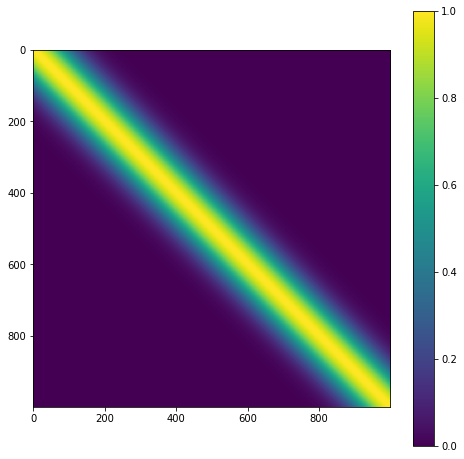

In [2]:
"""Here is a sample calculation for how the kernel is made and what it looks like."""
# Fake data is generated.
U = np.linspace(-100, 100, num=1000)
V = np.linspace(-100, 100, num=1000)
u1, u2 = np.meshgrid(U, U)
v1, v2 = np.meshgrid(V, V)

# Model parameters are set.
var_s = 1
sigma_x = 20
sigma_y = 20
theta = (0 * u.deg).to(u.rad)

# Rotation is calculated
a = np.cos(theta)**2 / (2 * sigma_x**2) + np.sin(theta)**2 / (2 * sigma_y**2)
b = - np.sin(2 * theta) / (4 * sigma_x**2) + np.sin(2 * theta) / (4 * sigma_y**2)
c = np.sin(theta)**2 / (2 * sigma_x**2) + np.cos(theta)**2 / (2 * sigma_y**2)

def Kernel(u1, u2, v1, v2, a, b, c):
    """Return 2D ellipstical kernel."""
    x = a * (u1 - u2)**2
    y = c * (v1 - v2)**2
    xy = 2 * b * (u1 - u2)*(v1 - v2)
    return np.exp(-(x + y + xy))

K = Kernel(u1, u2, v1, v2, a, b, c)
plt.figure(figsize=(8, 8))
plt.imshow(K)
plt.colorbar()
plt.show()

Previously I had been using a kernel of the form:
\begin{equation}
K(\vec{x_1}, \vec{x_2}) = \sigma_{signal} * exp(-(\frac{(u_1 - u_2)^2}{l_{xx}} + \frac{(v_1 - v_2)^2}{l_{yy}} + \frac{(u_1 - u_2)(v_1 - v_2)}{l_{xy}}))
\end{equation}

for
\begin{equation}
\vec{x_i} = (u_i, v_i)
\end{equation}
This form of the kernel was causing me lots of problems when running MCMC. One problem was that when $l_{xy}$ would dip below about 0.01, the kernel stopped being positive definite (probably due to calculation instability). Also, certain values of $l_{xx}$ and $l_{yy}$ would make the kernel not be positive definite though I couldn't figure out what exactly those values were.

I think the main problem was that since $l_{xx}$, $l_{yy}$, and $l_{xy}$ were all in the denominator, the kernel was very sensitive to these values and would explode very easily and make the kernel not positive definite. This makes it awkward for setting bounds for the MCMC algorithm because what do you use as a lower bound? 1e-6? 1e-10? 1e-2? I felt that any value would be hurting the flexibility of the algorithm.

Using the new kernel, above, my parameters are now ($\sigma_{signal}$, $\sigma_x$, $\sigma_y$, $\theta$) as opposed to ($\sigma_{signal}$, $l_{xx}$, $l_{yy}$, $l_{xy}$). Of course, $\sigma_x$ and $\sigma_y$ are still in a denominator, however I have had no problems with calculation instability (so far) with this new kernel even with simply setting the lower bound of $\sigma_{signal}$, $\sigma_x$, and $\sigma_y$ to 0. I believe it is also a good improvement that an angle $\theta$ is being used instead of $l_{xy}$ since $\theta$ requires no upper or lower bound.

Let me know if any of my reasoning above is wrong or flawed, or if I should be doing something completely different. However, now I will present some preliminary MCMC results.

In order to make MCMC quicker, I have been testing using only a small patch of one exposure. Specifically, I've been using the patch between -0.2 $\leq$ u $\leq$ 0 and 0 $\leq$ v $\leq$ 0.2. This reduces the calculation of the posterior to a few milliseconds, meaning that it only takes about 20 minutes to run 100,000 steps (on folio blanco using, I think, 12 cores).

In [3]:
# Initialize a GPR (Gaussian Process Regressor) object.
GP = gpr.GPR(
    '/data4/paper/fox/DES/austinFull.fits',   # fits file
    500,                                      # exposure number
    sample=np.array([-0.2, 0, 0, 0.2]),       # take only a small portion of the available exposure
    verbose=False,                            # print what it's calculating (not helpful when running 100,000 steps)
    eps=0,                                    # jitter for stability (not needed since our White kernel does this job)
    test_size=0.2,                            # portion of data to use as validation set
    random_state=0)                           # random seed to ensure reproducibility

In [4]:
# Define the likelihood function (see Algorithim 2.1 in Rasmussen and Williams).
# The actual calculation of the log marginal likelihood is inside the GPR class in gpr.py.
def LML(GP, theta):
    """Return log marginal likelihood."""
    GP.fit(theta)
    LML = GP.get_LML()
    return LML

In [5]:
# Define initial parameter values (theta_0).
var_s = 100
sigma_x = ((5 * u.arcmin).to(u.deg)).value
sigma_y = sigma_x
phi = (0 * u.deg).to(u.rad).value  # This rotation angle is called phi to avoid confusion with model parameters, theta.

theta0 = np.array([var_s, sigma_x, sigma_y, phi])

In [6]:
# Set step size
step_size = np.array([5, 5e-4, 5e-4, 1e-7])

I arrived at these step size values after running and tweaking $\theta_0$ in order to achieve an acceptance rate of as close to 44% as I could. I do recognize, however, that since these step sizes were tweaked using only a portion of the availabile data (not the entire exposure, see `sample` above) that these may not be appropriate when running this MCMC on the entire exposure.

In [7]:
# Labels for plotting later on
names = np.array(['var_s', 'sigma_x', 'sigma_y', 'phi'])

In [8]:
# Initialize MCMC with likelihood function, model data (contained in the GPR object), 
# step size, names, and another random seed. This random seed determines the random 
# steps taken in the algorithm.
estimator = mcmc.MCMC(LML, GP, theta0, step_size, names=names, seed=0)
print(f"For future reference, the current log marginal likelihood is: {estimator.current_loglike}")

For future reference, the current log marginal likelihood is: -100885.17426868042


In [9]:
%%time
# 10,000 steps are burned (returned values are not saved or plotted), and then
# 100,000 stepes are taken.
estimator.burn(10000)
estimator.run(100000)

CPU times: user 3h 30min 19s, sys: 12min 27s, total: 3h 42min 47s
Wall time: 18min 33s


In [10]:
print(f"Fraction of steps accepted: {estimator.accept_fraction()}")
print(f"Current log marginal likelihood: {estimator.current_loglike}")

Number of steps accepted: 0.38381
Current log marginal likelihood: -1351.3910432844548


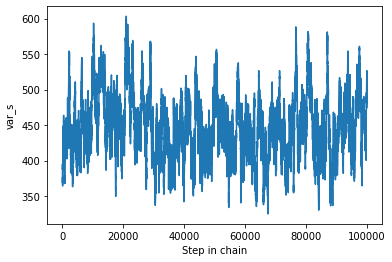

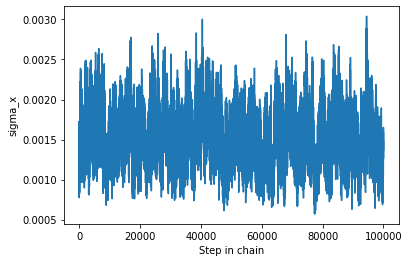

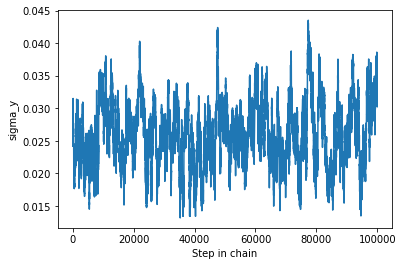

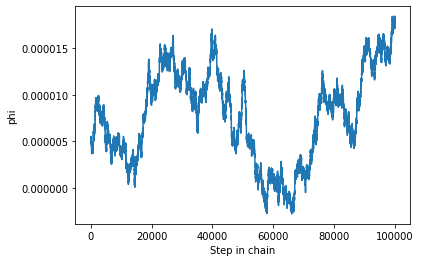

In [11]:
# This function plots the value of each parameter after each saved step.
estimator.plot_samples()

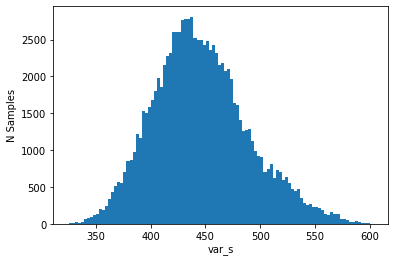

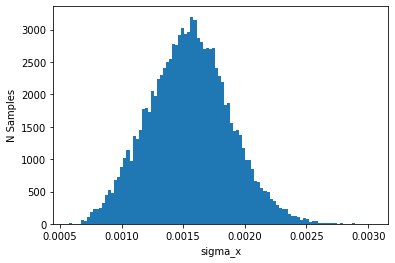

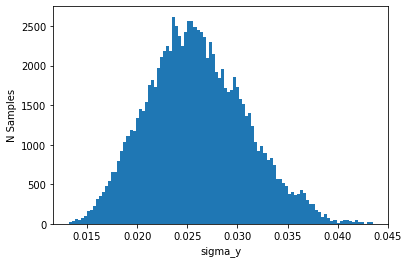

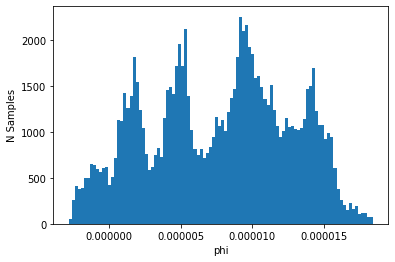

In [12]:
# This function plots the histogram of each parameter for all saved steps.
estimator.plot_hist()

Assuming I've done everything else correct, these histograms (apart from the last one) make it pretty clear what the actual value should be.

I'm not really sure what to make of the last one. I'm not sure why we're seeing multiple peaks here. Any ideas?

I also find it concerning that theta is so close to 0 degrees.

In [23]:
# here are the average parameter values from the 100,000 saved steps
mu = estimator.calculate_mean()
print(f"sigma_x: {np.round((mu[1] * u.deg).to(u.arcmin), 3)}, sigma_y: {np.round((mu[2] * u.deg).to(u.arcmin), 3)}")
print(f"var_s: {np.round(mu[0], 3)}, theta: {np.round((mu[3]*u.rad).to(u.deg), 6)}")

sigma_x: 0.093 arcmin, sigma_y: 1.556 arcmin
var_s: 445.911, theta: 0.000442 deg


Current Log Marginal Likelihood: -1349.4721691706477
Standard deviation of validation residuals: dx 7.84, dy 14.489
Standard deviation of Gaussian Process residuals: dx 9.534, dy 9.573
The ratio of validation residuals over GP residuals is: dx 0.822, dy 1.514


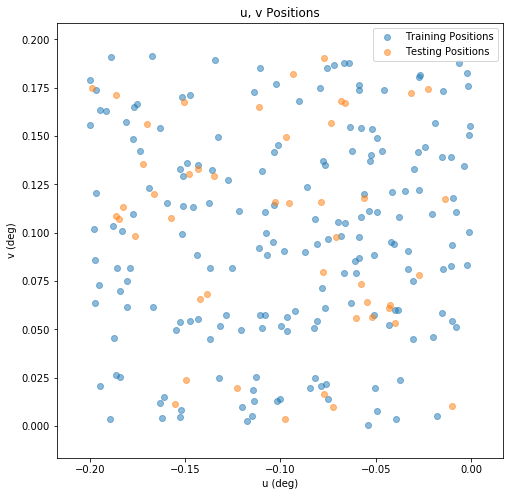

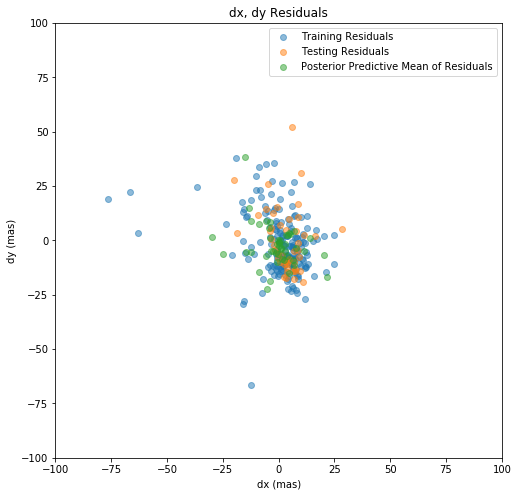

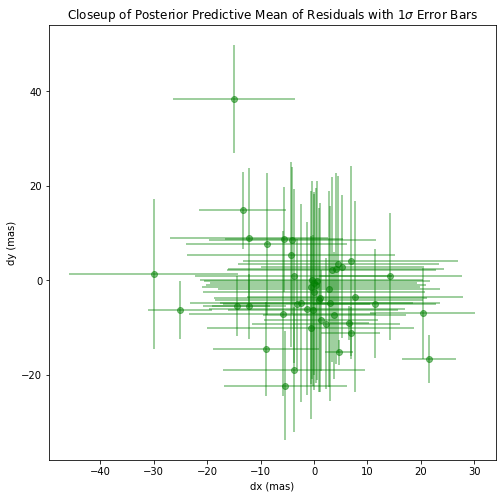

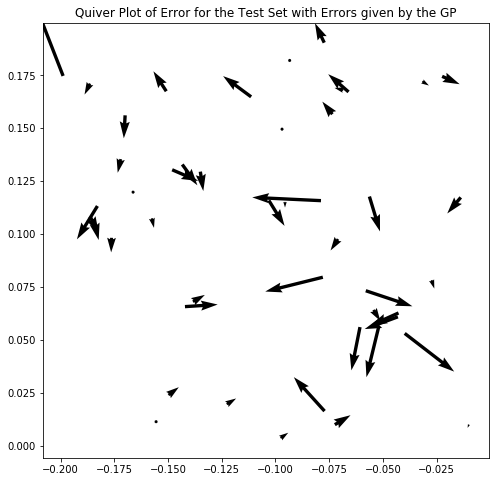

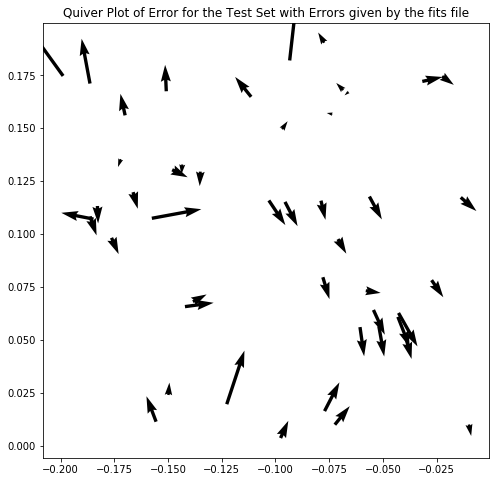

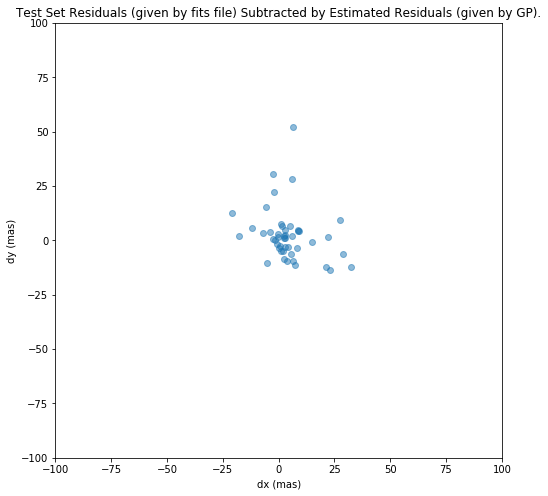

In [24]:
# Initialize and fit a new GPR model with these values
GP = gpr.GPR(
    '/data4/paper/fox/DES/austinFull.fits',
    500,
    sample=np.array([-0.2, 0, 0, 0.2]),
    verbose=False,
    eps=0,
    test_size=0.2,
    random_state=0)
GP.fit(estimator.calculate_mean())
GP.summary()

The last time we met you asked me to find the standard deviation of the validation residuals, and the standard deviation of the GP residuals, but I'm unsure as to why this is an accurate measure of the error. It makes more sense to me that we should be looking at the standard deviation of the validation residuals minus the GP residuals. Could you explain to me why the former is useful?